In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# #check file paths for data paths 
# from os import listdir

# #list files/directories in current directory
# for file in listdir("./"):
#     print(file)
    
train_path = "./data/train.csv"
test_path = "./data/test.csv"
test_labels_path = "./data/test_labels.csv"

#load data with pandas and return dataframes 
def load_data(train_path, test_path, test_labels_path):
    train = pd.read_csv(train_path)
    print(train[0:10])
    test = pd.read_csv(test_path)
    test_labels = pd.read_csv(test_labels_path)
    cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']
    return train, test, test_labels, cols_target


train, test, test_labels, cols = load_data(train_path, test_path, test_labels_path)

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   
5  00025465d4725e87  "\n\nCongratulations from me as well, use the ...      0   
6  0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK      1   
7  00031b1e95af7921  Your vandalism to the Matt Shirvington article...      0   
8  00037261f536c51d  Sorry if the word 'nonsense' was offensive to ...      0   
9  00040093b2687caa  alignment on this subject and which are contra...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0          

In [55]:
# print(train[0:10])

In [56]:
# #summarize data
# def summary():
#     labels = train.iloc[:,2:]
#     zero = np.where(np.sum(labels,axis=1)==0)
#     # Find the unlabelled percentage
#     unlabelled = train[(train['toxic']!=1) & (train['severe_toxic']!=1) &\
#                                  (train['obscene']!=1) & (train['threat']!=1) &\
#                                  (train['insult']!=1) & (train['identity_hate']!=1)]
#     print("Train data length: ", len(train))
#     print("Test data length: ", len(test))
#     print('\nPercentage of unlabelled: ', len(unlabelled)/len(train)*100)
#     print(train[cols].sum())

#     train[cols].sum().plot.bar(title ="Number of Comments by Label")

# summary()

In [41]:
def get_data(num_to_use): 
    #temporarily only use 500 
    train_comments = train.iloc[0:num_to_use,1]
    test_comments = test.iloc[0:num_to_use,1]
    
    return test_comments, train_comments

test_comments, train_comments= get_data(len(train))


# each label as a single combined string, e.g. toxic & severe_toxic = 11
def get_labels_as_vec(num_to_use):
    #labels as numpy 
    labels = train.iloc[0:num_to_use,2:]
    labels['vector_label'] = labels.astype(str).values.sum(axis=1)
    train_labels = labels['vector_label']
    return train_labels

#alternate : each label as a separate pd column
def get_labels_as_cols(num_to_use):
    #labels as pd dataframes
    toxic_train_labels = train.iloc[0:num_to_use,2:3]
    severe_toxic_labels = train.iloc[0:num_to_use,3:4] 
    obscene_labels = train.iloc[0:num_to_use,4:5] 
    threat_labels = train.iloc[0:num_to_use,5:6] 
    insult_labels = train.iloc[0:num_to_use,6:7] 
    identity_hate_labels = train.iloc[0:num_to_use,7:8] 
    
    return toxic_train_labels, severe_toxic_labels, obscene_labels, threat_labels, insult_labels, identity_hate_labels

toxic_train_labels, severe_toxic_labels, obscene_labels, threat_labels, insult_labels, identity_hate_labels = get_labels_as_cols(len(train))



In [52]:
#vectorize inputs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

def vectorize_tfidf(): 
    vectorizer = TfidfVectorizer(max_df=0.5, stop_words='english')
    features_train = vectorizer.fit_transform(train_comments)
    features_test = vectorizer.fit_transform(test_comments)
    train_vocab = vectorizer.get_feature_names()
#     print(train_vocab)
    return features_train, features_test, vectorizer

def vectorize_count():
    vectorizer = CountVectorizer(max_df=0.5, stop_words='english', ngram_range=(1,2))
    features_train = vectorizer.fit_transform(train_comments)
    features_test = vectorizer.fit_transform(test_comments)
    train_vocab = vectorizer.get_feature_names()
#     print(train_vocab)
    return features_train, features_test, vectorizer


count_features_train, count_features_test, count_vectorizer = vectorize_count()

tfidf_features_train, tfidf_features_test, tfidf_vectorizer = vectorize_tfidf()

print(count_features_train.shape)

(159571, 2845813)


In [57]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer, recall_score, precision_score, accuracy_score
from sklearn.model_selection import cross_validate

def train_model(labels):
    model = MultinomialNB()
    model.fit(features_train, labels)
    score = model.score(features_train, labels)
    return score, model


def get_avg_cvd_score(model, X, y):
    to_get = { 'accuracy' : make_scorer(accuracy_score),
    'precision' : make_scorer(precision_score, average='macro'),
    'recall' : make_scorer(recall_score, average='macro')}
    results = cross_validate(model, X, y, scoring=to_get, cv=5)

    return np.average(results['test_accuracy']), np.average(results['test_precision']), np.average(results['test_recall'])

#toxic
score_toxic, _ = train_model(toxic_train_labels.values.ravel())
toxic_accuracy, toxic_precision, toxic_recall = get_avg_cvd_score(MultinomialNB(), features_train, toxic_train_labels.values.ravel())
print("toxic")
print("training accuracy: " + str(score_toxic))
print("validation accuracy: " + str(toxic_accuracy))
print("precision: " +str(toxic_precision))
print("recall: " +str(toxic_recall))
print("\n")

#severe_toxic_labels
print("severe_toxic")
score_severe_toxic, _ = train_model(severe_toxic_labels.values.ravel())
toxic_accuracy, toxic_precision, toxic_recall = get_avg_cvd_score(MultinomialNB(), features_train, severe_toxic_labels.values.ravel())
print(score_severe_toxic)
print("validation accuracy: " + str(toxic_accuracy))
print("precision: " +str(toxic_precision))
print("recall: " +str(toxic_recall))
print("\n")

#obscene_labels
print("obscene")
score_obscene, _ = train_model(obscene_labels.values.ravel())
toxic_accuracy, toxic_precision, toxic_recall = get_avg_cvd_score(MultinomialNB(), features_train, obscene_labels.values.ravel())
print(score_obscene)
print("validation accuracy: " + str(toxic_accuracy))
print("precision: " +str(toxic_precision))
print("recall: " +str(toxic_recall))
print("\n")

#threat_labels
print("threat")
score_threat, _ = train_model(threat_labels.values.ravel())
toxic_accuracy, toxic_precision, toxic_recall = get_avg_cvd_score(MultinomialNB(), features_train, threat_labels.values.ravel())
print(score_threat)
print("validation accuracy: " + str(toxic_accuracy))
print("precision: " +str(toxic_precision))
print("recall: " +str(toxic_recall))
print("\n")

#insult_labels
print("insult")
score_insult, _ = train_model(insult_labels.values.ravel())
toxic_accuracy, toxic_precision, toxic_recall = get_avg_cvd_score(MultinomialNB(), features_train, insult_labels.values.ravel())
print(score_insult)
print("validation accuracy: " + str(toxic_accuracy))
print("precision: " +str(toxic_precision))
print("recall: " +str(toxic_recall))
print("\n")

#identity_hate_labels
print("identity_hate")
score_identity_hate, _ = train_model(identity_hate_labels.values.ravel())
toxic_accuracy, toxic_precision, toxic_recall = get_avg_cvd_score(MultinomialNB(), features_train, identity_hate_labels.values.ravel())
print(score_identity_hate)
print("validation accuracy: " + str(toxic_accuracy))
print("precision: " +str(toxic_precision))
print("recall: " +str(toxic_recall))


In [65]:
#clean test data
# print(test[0:5])
# print(test_labels.loc[test_labels['toxic'] == 1])
# print(test_labels[0:15])

#remove all unlabeled test data 
unlabeled = []
unlabeled.extend(test_labels.index[test_labels['toxic'] == -1])
print(len(test_labels.loc[test_labels['toxic'] == -1]))
print("before: " + str(len(test)))
print("before: " + str(len(test_labels)))
test_labels = test_labels.drop(test_labels.index[unlabeled])
test = test.drop(test.index[unlabeled])
print("after: " + str(len(test)))
print("after: " + str(len(test_labels)))
print("labels: " + str(test_labels[0:10]))

0
before: 63978
before: 63978
after: 63978
after: 63978
labels:                   id  toxic  severe_toxic  obscene  threat  insult  \
5   0001ea8717f6de06      0             0        0       0       0   
7   000247e83dcc1211      0             0        0       0       0   
11  0002f87b16116a7f      0             0        0       0       0   
13  0003e1cccfd5a40a      0             0        0       0       0   
14  00059ace3e3e9a53      0             0        0       0       0   
16  000663aff0fffc80      0             0        0       0       0   
17  000689dd34e20979      0             0        0       0       0   
19  000844b52dee5f3f      0             0        0       0       0   
21  00091c35fa9d0465      1             0        0       0       0   
22  000968ce11f5ee34      0             0        0       0       0   

    identity_hate  
5               0  
7               0  
11              0  
13              0  
14              0  
16              0  
17              0  
19   

In [78]:
#run test data: we will use tfidf for severe toxic, threat, and identity hate
#and we will use countvectorizer: less severe labels, i.e. toxic, obscene, and insult.
def get_data(num_to_use, data): 
    comments = data.iloc[0:num_to_use,1]
    return comments

test_comments = get_data(len(test), test)
# print(test_comments)
train_comments = get_data(len(train), train)
# print(train_comments)

def vectorize_tfidf(): 
    vectorizer = TfidfVectorizer(max_df=0.5, stop_words='english')
    features_train = vectorizer.fit_transform(train_comments)
    features_test = vectorizer.transform(test_comments)
    train_vocab = vectorizer.get_feature_names()
#     print(train_vocab)
    return features_train, features_test, vectorizer

def vectorize_count():
    vectorizer = CountVectorizer(max_df=0.5, stop_words='english', ngram_range=(1,2))
    features_train = vectorizer.fit_transform(train_comments)
    features_test = vectorizer.transform(test_comments)
    train_vocab = vectorizer.get_feature_names()
#     print(train_vocab)
    return features_train, features_test, vectorizer

def get_test_labels_as_cols(num_to_use, test_labels):
    #labels as pd dataframes
    toxic_train_labels = test_labels.iloc[0:num_to_use,2:3]
    severe_toxic_labels = test_labels.iloc[0:num_to_use,3:4] 
    obscene_labels = test_labels.iloc[0:num_to_use,4:5] 
    threat_labels = test_labels.iloc[0:num_to_use,5:6] 
    insult_labels = test_labels.iloc[0:num_to_use,6:7] 
    identity_hate_labels = test_labels.iloc[0:num_to_use,7:8] 
    
    return toxic_train_labels, severe_toxic_labels, obscene_labels, threat_labels, insult_labels, identity_hate_labels

def train_model(labels, features):
    model = MultinomialNB()
    model.fit(features, labels)
    score = model.score(features, labels)
    return score, model

count_features_train, count_features_test, count_vectorizer = vectorize_count()
tfidf_features_train, tfidf_features_test, tfidf_vectorizer = vectorize_tfidf()

toxic_train_labels, severe_toxic_labels, obscene_labels, threat_labels, insult_labels, identity_hate_labels = get_test_labels_as_cols(len(train), train)

#toxic
#train model, then get labels for test data
print("toxic")
score_toxic, model = train_model(toxic_train_labels.values.ravel(), count_features_train)
toxic_labels = model.predict(count_features_test)

# severe_toxic_labels
print("severe_toxic")
score_severe_toxic, model = train_model(severe_toxic_labels.values.ravel(), tfidf_features_train)
severe_toxic_labels = model.predict(tfidf_features_test)


# #obscene_labels
print("obscene")
score_obscene, model = train_model(obscene_labels.values.ravel(), count_features_train)
obscene_labels = model.predict(count_features_test)

#threat_labels
print("threat")
score_threat, model = train_model(threat_labels.values.ravel(), tfidf_features_train)
threat_labels = model.predict(tfidf_features_test)

#insult_labels
print("insult")
score_insult, model = train_model(insult_labels.values.ravel(), count_features_train)
insult_labels = model.predict(count_features_test)

# identity_hate_labels
print("identity_hate")
score_identity_hate, model = train_model(identity_hate_labels.values.ravel(), tfidf_features_train)
identity_hate_labels = model.predict(tfidf_features_test)


#combine all labels
labels = pd.DataFrame({'toxic': toxic_labels, 'severe_toxic': severe_toxic_labels, 'obscene': obscene_labels, 'threat': threat_labels, 'insult': insult_labels, 'identity_hate': identity_hate_labels})
print(labels.head)
print(len(labels))
print("labels: " + str(test_labels[0:10]))

toxic
[0 0 0 ... 0 1 0]
severe_toxic
obscene
threat
insult
identity_hate
<bound method NDFrame.head of        toxic  severe_toxic  obscene  threat  insult  identity_hate
0          0             0        0       0       0              0
1          0             0        0       0       0              0
2          0             0        0       0       0              0
3          0             0        0       0       0              0
4          0             0        0       0       0              0
5          0             0        0       0       0              0
6          0             0        0       0       0              0
7          0             0        0       0       0              0
8          0             0        0       0       0              0
9          0             0        0       0       0              0
10         0             0        0       0       0              0
11         0             0        0       0       0              0
12         0             0

In [87]:
#calculate accuracy
print("num predicted labels: " + str(len(labels)))
print("num actual labels: " + str(len(test_labels)))

#drop indices so we can compare 
labels = labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

total = len(res)

#toxic
res = np.where(labels['toxic'] == test_labels['toxic'], 1, 0)
count_correct = sum(res)
toxic_accuracy = count_correct/total
print("toxic_accuracy: " + str(toxic_accuracy))

#severe_toxic
res = np.where(labels['severe_toxic'] == test_labels['severe_toxic'], 1, 0)
count_correct = sum(res)
accuracy = count_correct/total
print("severe_toxic_accuracy: " + str(accuracy))

#obscene
res = np.where(labels['obscene'] == test_labels['obscene'], 1, 0)
count_correct = sum(res)
accuracy = count_correct/total
print("obscene_accuracy: " + str(accuracy))

#threat
res = np.where(labels['threat'] == test_labels['threat'], 1, 0)
count_correct = sum(res)
accuracy = count_correct/total
print("threat_accuracy: " + str(accuracy))

#insult
res = np.where(labels['insult'] == test_labels['insult'], 1, 0)
count_correct = sum(res)
accuracy = count_correct/total
print("insult_accuracy: " + str(accuracy))

#identity hate
res = np.where(labels['identity_hate'] == test_labels['identity_hate'], 1, 0)
count_correct = sum(res)
accuracy = count_correct/total
print("identity_hate_accuracy: " + str(accuracy))


num predicted labels: 63978
num actual labels: 63978
toxic_accuracy: 0.9322892244208947
severe_toxic_accuracy: 0.9942636531307637
obscene_accuracy: 0.9572352996342492
threat_accuracy: 0.9967019913095126
insult_accuracy: 0.954453093250805
identity_hate_accuracy: 0.9888711744662227


In [103]:
#train model on all data (including the labeled test data + given train data)
#run test data: we will use tfidf for severe toxic, threat, and identity hate
#and we will use countvectorizer: less severe labels, i.e. toxic, obscene, and insult.
def get_data(num_to_use, data): 
    comments = data.iloc[0:num_to_use,1]
    return comments

test_comments = get_data(len(test), test)
# print(test_comments)
train_comments = get_data(len(train), train)
# print(train_comments)

#combine the comments 
comments = pd.concat([train_comments, test_comments])
# print(comments)

# #combine the labels: drop indices 
# print(len(train) + len(test_labels))
train_labels = train.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)
labels = pd.concat([train_labels, test_labels], sort=False)
# print(len(labels))

def vectorize_tfidf(): 
    vectorizer = TfidfVectorizer(max_df=0.5, stop_words='english')
    features_train = vectorizer.fit_transform(train_comments)
    features_test = vectorizer.transform(test_comments)
    train_vocab = vectorizer.get_feature_names()
#     print(train_vocab)
    return features_train, features_test, vectorizer

def vectorize_count():
    vectorizer = CountVectorizer(max_df=0.5, stop_words='english', ngram_range=(1,2))
    features_train = vectorizer.fit_transform(train_comments)
    features_test = vectorizer.transform(test_comments)
    train_vocab = vectorizer.get_feature_names()
#     print(train_vocab)
    return features_train, features_test, vectorizer

def get_test_labels_as_cols(num_to_use, test_labels):
    #labels as pd dataframes
    toxic_train_labels = test_labels.iloc[0:num_to_use,2:3]
    severe_toxic_labels = test_labels.iloc[0:num_to_use,3:4] 
    obscene_labels = test_labels.iloc[0:num_to_use,4:5] 
    threat_labels = test_labels.iloc[0:num_to_use,5:6] 
    insult_labels = test_labels.iloc[0:num_to_use,6:7] 
    identity_hate_labels = test_labels.iloc[0:num_to_use,7:8] 
    
    return toxic_train_labels, severe_toxic_labels, obscene_labels, threat_labels, insult_labels, identity_hate_labels

def train_model(labels, features):
    model = MultinomialNB()
    model.fit(features, labels)
    score = model.score(features, labels)
    return score, model

count_features_train, count_features_test, count_vectorizer = vectorize_count()
tfidf_features_train, tfidf_features_test, tfidf_vectorizer = vectorize_tfidf()

toxic_train_labels, severe_toxic_labels, obscene_labels, threat_labels, insult_labels, identity_hate_labels = get_test_labels_as_cols(len(train), train)

#toxic
#train model, then get labels for test data
print("toxic")
score, model_toxic = train_model(toxic_train_labels.values.ravel(), count_features_train)
toxic_labels = model_toxic.predict(count_features_test)
print(score)

# severe_toxic_labels
print("severe_toxic")
score, model_severe = train_model(severe_toxic_labels.values.ravel(), tfidf_features_train)
severe_toxic_labels = model_severe.predict(tfidf_features_test)
print(score)


# #obscene_labels
print("obscene")
score, model_obscene = train_model(obscene_labels.values.ravel(), count_features_train)
obscene_labels = model_obscene.predict(count_features_test)
print(score)

#threat_labels
print("threat")
score, model_threat = train_model(threat_labels.values.ravel(), tfidf_features_train)
threat_labels = model_threat.predict(tfidf_features_test)
print(score)

#insult_labels
print("insult")
score, model_insult = train_model(insult_labels.values.ravel(), count_features_train)
insult_labels = model_insult.predict(count_features_test)
print(score)

# identity_hate_labels
print("identity_hate")
score, model_identity_hate = train_model(identity_hate_labels.values.ravel(), tfidf_features_train)
identity_hate_labels = model_identity_hate.predict(tfidf_features_test)
print(score)

toxic
0.9753150635140471
severe_toxic
0.9899417814013824
obscene
0.9827976261350747
threat
0.9969856678218473
insult
0.9793195505448985
identity_hate
0.9911387407486323


In [148]:
#load tweets and find the toxic tweets
tweet_path = "./data/tweetsUsers.csv"

#load data with pandas and return dataframes 
def load_tweets(tweet_path):
    tweets = pd.read_csv(tweet_path)
    comments = tweets['text']
    users = tweets['screen_name']
    return comments, users

tweets, users = load_tweets(tweet_path)

#print(tweets[0:10])

def vectorize_tfidf(docs): 
    features = tfidf_vectorizer.transform(docs)
    return features

def vectorize_count(docs):
    features = count_vectorizer.transform(docs)
    return features

count_features_test = vectorize_count(tweets)
tfidf_features_test = vectorize_tfidf(tweets)

#toxic
#train model, then get labels for test data
print("toxic")
toxic_labels = model_toxic.predict(count_features_test)

# severe_toxic_labels
print("severe_toxic")
severe_toxic_labels = model_severe.predict(tfidf_features_test)

# #obscene_labels
print("obscene")
obscene_labels = model_obscene.predict(count_features_test)

#threat_labels
print("threat")
threat_labels = model_threat.predict(tfidf_features_test)

#insult_labels
print("insult")
insult_labels = model_insult.predict(count_features_test)

# identity_hate_labels
print("identity_hate")
identity_hate_labels = model_identity_hate.predict(tfidf_features_test)
    
#combine labels
labels = pd.DataFrame({'toxic': toxic_labels, 'severe_toxic': severe_toxic_labels, 'obscene': obscene_labels, 'threat': threat_labels, 'insult': insult_labels, 'identity_hate': identity_hate_labels})


toxic
severe_toxic
obscene
threat
insult
identity_hate


In [149]:
#data analysis
num_toxic = sum(np.where(labels['toxic'] == 1, 1, 0))
toxic = labels.index[labels['toxic'] == 1].tolist()
severe = labels.index[labels['severe_toxic'] == 1].tolist()
obscene = labels.index[labels['obscene'] == 1].tolist()
threat = labels.index[labels['threat'] == 1].tolist()
insult = labels.index[labels['insult'] == 1].tolist()
identity_hate = labels.index[labels['identity_hate'] == 1].tolist()

# print(tweets.loc[toxic])
# print(users.loc[toxic])
flagged_users = pd.concat([users.loc[toxic], users.loc[severe], users.loc[obscene], users.loc[threat], users.loc[insult], users.loc[identity_hate]])
flagged_tweets = pd.concat([tweets.loc[toxic], tweets.loc[severe], tweets.loc[obscene], tweets.loc[threat], tweets.loc[insult], tweets.loc[identity_hate]])

df = pd.DataFrame({'users': flagged_users, 'tweets': flagged_tweets})

df.drop_duplicates() #remove any repeated comments
df.sort_values(by=['users'])
df.to_csv("data/toxic_tweets1.csv")


# num_toxic = sum(np.where(labels['severe_toxic'] == 1, 1, 0))
# print(num_toxic)

# num_toxic = sum(np.where(labels['obscene'] == 1, 1, 0))
# print(num_toxic)

# num_toxic = sum(np.where(labels['threat'] == 1, 1, 0))
# print(num_toxic)

# num_toxic = sum(np.where(labels['insult'] == 1, 1, 0))
# print(num_toxic)

# num_toxic = sum(np.where(labels['identity_hate'] == 1, 1, 0))
# print(num_toxic)



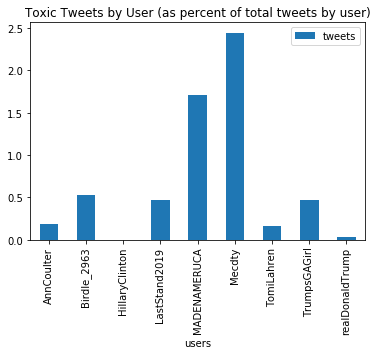

In [150]:
 def summarize():
    count_tweets = pd.DataFrame({'users':users, 'tweets': tweets})
    user_total = count_tweets.groupby(['users']).count()
    user_flagged = df.groupby(['users']).count()
    percent = user_flagged/user_total * 100
    percent.plot(kind='bar', title="Toxic Tweets by User (as percent of total tweets by user)")

summarize()

In [ ]:
# import random
# from langdetect import detect
# import re

# sentence = ""
# vocab = list(vectorizer.vocabulary_.keys())
# cut = int(3.0 * len(vocab) / 4.0)
# vocab = vocab[:len(vocab) - cut]
# sentenceLength = int(random.random() * 8) + 3
# for i in range(sentenceLength):
#     word = ""
#     isEnglish = False
#     while not isEnglish:
#         falloff = 5
#         sample = random.random() ** falloff
#         index = int(sample * len(vocab))
#         word = vocab[index]
#         word = "".join(re.split("[^a-zA-Z]*", word))
#         if word == "":
#             continue
#         isEnglish = (detect(word) == "en")
    
#     sentence += " " + word
    
# print(sentence)